In [2]:
# randomly sample an image from 10_000 images
# extract the channels, convert each to black and white and display
# perform dwt on the image and extract only the LL feature and dislay it
# use a vae to encode it, and display each channel in black and white
# perform dwt on the encoded image and then extract onlt the LL features, display each on in blck and white

Using device: cuda
Loading VAE model...
Processing image: D:\DDP_amit_sethi\workspace-fast-dit\tiny-image-net-20-500\n01443537\images\n01443537_0.JPEG


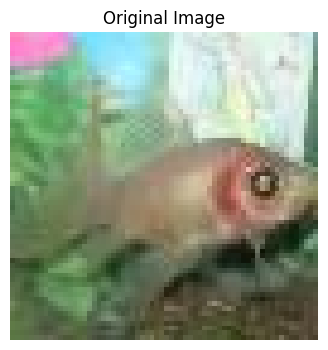


=== Step 1: Original Image Channels ===


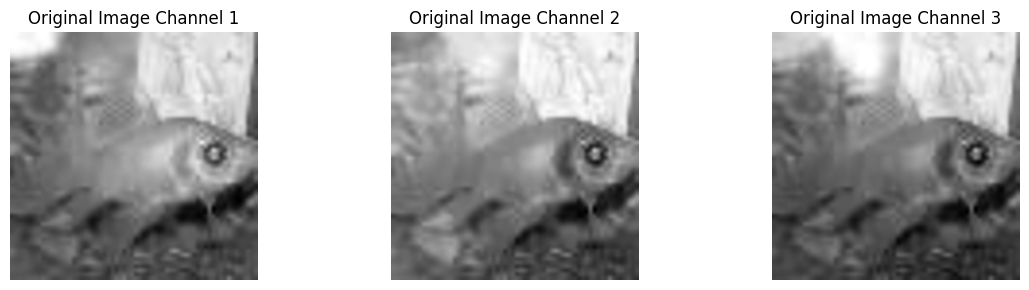


=== Step 2: DWT on Original Image (LL features) ===


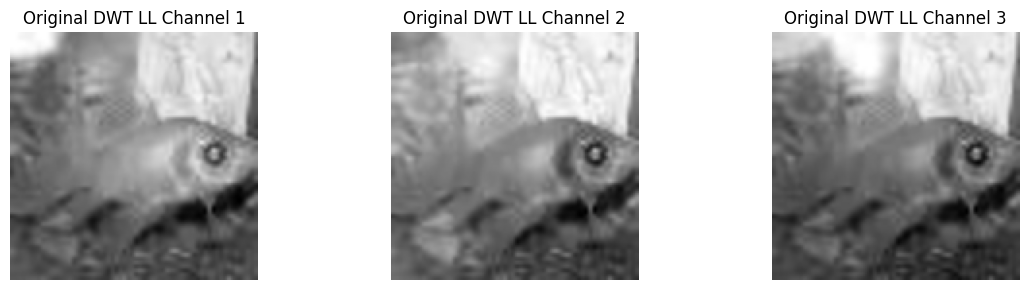


=== Step 3: VAE Encoding ===
VAE encoded shape: torch.Size([1, 4, 32, 32])


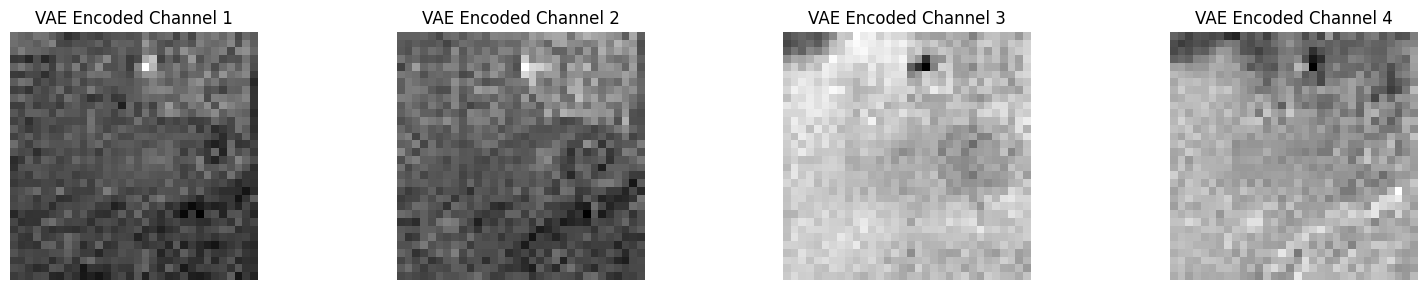


=== Step 4: DWT on VAE Encoded (LL features) ===


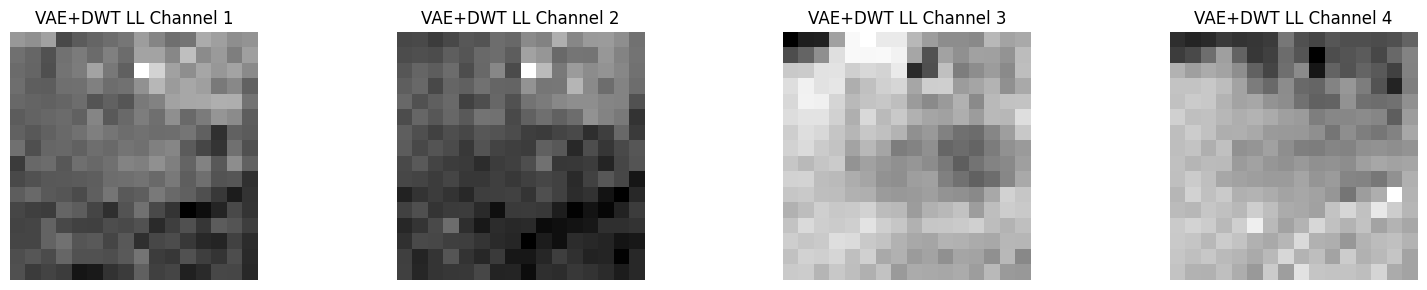

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from diffusers import AutoencoderKL
import random
import os
from pytorch_wavelets import DWTForward
import glob

def center_crop_arr(pil_image, image_size):
    """
    Center cropping implementation from ADM.
    """
    while min(*pil_image.size) >= 2 * image_size:
        pil_image = pil_image.resize(
            tuple(x // 2 for x in pil_image.size), resample=Image.BOX
        )

    scale = image_size / min(*pil_image.size)
    pil_image = pil_image.resize(
        tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
    )

    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return Image.fromarray(arr[crop_y: crop_y + image_size, crop_x: crop_x + image_size])

def extract_dwt_features(latent, num_dwt_levels=1, device='cpu'):
    """
    Extract features from the latent representation using Discrete Wavelet Transform (DWT).
    """
    dwt = DWTForward(J=num_dwt_levels, wave='haar', mode='zero').to(device)
    ll, _ = dwt(latent)
    return ll

def load_random_images(image_folder, num_images=10000, sample_size=1):
    """
    Load random images from a folder containing up to num_images
    """
    # Get all image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    all_images = []
    for ext in image_extensions:
        all_images.extend(glob.glob(os.path.join(image_folder, '**', ext), recursive=True))
    
    # Limit to num_images and randomly sample
    available_images = all_images[:num_images] if len(all_images) > num_images else all_images
    sampled_images = random.sample(available_images, min(sample_size, len(available_images)))
    
    return sampled_images

def display_channels(image_tensor, title_prefix=""):
    """
    Display each channel of an image tensor in black and white
    """
    if len(image_tensor.shape) == 4:  # (batch, channels, height, width)
        image_tensor = image_tensor[0]  # Take first batch item
    
    channels = image_tensor.shape[0]
    fig, axes = plt.subplots(1, channels, figsize=(4*channels, 3))
    
    if channels == 1:
        axes = [axes]
    
    for i in range(channels):
        channel_data = image_tensor[i].cpu().numpy()
        axes[i].imshow(channel_data, cmap='gray')
        axes[i].set_title(f'{title_prefix} Channel {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def process_and_visualize_image(image_path, image_size=512, vae_model="mse"):
    """
    Complete pipeline: load image -> show channels -> DWT -> VAE -> DWT on encoded
    """
    # Setup device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Load VAE model
    print("Loading VAE model...")
    vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{vae_model}").to(device)
    
    # Load and preprocess image
    print(f"Processing image: {image_path}")
    pil_image = Image.open(image_path).convert('RGB')
    
    # Show original image
    plt.figure(figsize=(4, 4))
    plt.imshow(pil_image)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    # Apply transformations
    transform = transforms.Compose([
        transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3, inplace=True)
    ])
    
    image_tensor = transform(pil_image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Step 1: Display original image channels
    print("\n=== Step 1: Original Image Channels ===")
    display_channels(image_tensor, "Original Image")
    
    # Step 2: Apply DWT to original image and show LL features
    print("\n=== Step 2: DWT on Original Image (LL features) ===")
    dwt_original = extract_dwt_features(image_tensor, num_dwt_levels=1, device=device)
    display_channels(dwt_original, "Original DWT LL")
    
    # Step 3: VAE encode the original image
    print("\n=== Step 3: VAE Encoding ===")
    with torch.no_grad():
        encoded = vae.encode(image_tensor).latent_dist.sample().mul_(0.18215)
    
    print(f"VAE encoded shape: {encoded.shape}")
    display_channels(encoded, "VAE Encoded")
    
    # Step 4: Apply DWT to VAE encoded image and show LL features
    print("\n=== Step 4: DWT on VAE Encoded (LL features) ===")
    dwt_encoded = extract_dwt_features(encoded, num_dwt_levels=1, device=device)
    display_channels(dwt_encoded, "VAE+DWT LL")
    
    return {
        'original': image_tensor,
        'dwt_original': dwt_original,
        'vae_encoded': encoded,
        'dwt_encoded': dwt_encoded
    }

# Example usage
if __name__ == "__main__":
    image_path = r"D:\DDP_amit_sethi\workspace-fast-dit\tiny-image-net-20-500\n01443537\images\n01443537_0.JPEG"  # Update this path
    process_and_visualize_image(image_path, image_size=256, vae_model="mse")
